# Exercise 5: Feature Extraction and Matching

In this exercise, you will learn:

- How to find key points in images and describe their features
- How to match key points between two views of the same scene

For some functions we already provide some draft implementation that you just need to complete. This is supposed to help you identifying the next steps.


## 0. Setup

Load all libraries and both views that we will work with.

In [98]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from PIL import Image
from scipy import signal

View 1 resolution: 449x600
View 2 resolution: 449x600


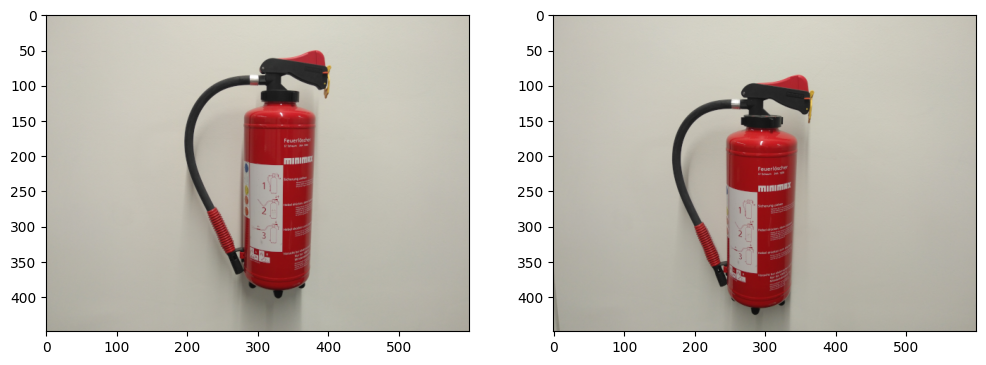

In [99]:
# Load images and resize
view1 = np.array(Image.open("data/exercise3/view1.png")) / 255
view2 = np.array(Image.open("data/exercise3/view2.png")) / 255

# Check resolution
print(f"View 1 resolution: {view1.shape[0]}x{view1.shape[1]}")
print(f"View 2 resolution: {view2.shape[0]}x{view2.shape[1]}")

# Show both views
_, axes = plt.subplots(1,2, figsize=(12,6))
axes[0].imshow(view1)
axes[1].imshow(view2)
plt.show()

## 1. Key Point Detection and Feature Extraction

You might want to look again into the concepts explained in slide decks "04_sparse_geometry_1_appearance_matching.pdf" and "03_image_processing_2.pdf

In this part of the exercise, you will learn how to build your own key point detector and feature descriptor. Generally, you should rather use the implementation of traditional and well-known feature descriptors such as [SIFT](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94), [ORB](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6126544), etc. But here, we will learn how to come up with our own method from scratch.

As a reminder: Feature extraction consists of two step. First, there is detection/localization of key points. Second, computing a feature vector for each key point to uniquely describe it.

### 1.1. Key Point Detection using Harris Corner Detector

Complete the implementation below. First you have to implement some helper functions (```smooth_image```, ```image_gradient```, ```compute_structure_tensor_Q```, ```compute_harris_score```, ```non_maximum_suppression```, ```compute_angles```). Finally you detect keypoints by implementing the function ```detect_corner_keypoints``` (and call your implemented helper functions from there). It is supposed to be a function that takes an image and some hyperparameters as inputs and returns a list of coordinates describing the location of detected key points. Furthermore, the orientation of the key point shall be returned. For key point detection you should apply the Harris detector to the image as dicussed in the lecture. For key point orientation, you should return the angle of the local gradient at each detected key point. The angle is important so that corresponding key points from differently rotated view points can be aligned. Hint: Use np.arctan2(x,y) for angle computation to get full 360 degree orientation.

In [100]:
from scipy.ndimage import sobel, gaussian_filter, maximum_filter

def to_grayscale(img: npt.ArrayLike) -> np.ndarray:
    channel_weights = [0.299, 0.587, 0.114]
    weighted_img = img * np.reshape(channel_weights, (1,1,3))
    return np.sum(weighted_img, axis=2)

def smooth_image(image: npt.ArrayLike, sigma: float = 1.0) -> np.ndarray:
    """Smooth the image with a Gaussian filter."""
    return gaussian_filter(image, sigma=sigma)

def image_gradient(image: npt.ArrayLike, axis: int) -> np.ndarray:
    """Compute the image gradients with the Sobel filter along the specified axis."""
    return sobel(image, axis=axis)

def compute_structure_tensor_Q(Ix: npt.ArrayLike, Iy: npt.ArrayLike, window_size: int) -> np.ndarray:
    """Compute the structure tensor Q."""
    Ixx = gaussian_filter(Ix**2, sigma=window_size/6)
    Iyy = gaussian_filter(Iy**2, sigma=window_size/6)
    Ixy = gaussian_filter(Ix*Iy, sigma=window_size/6)
    return np.stack((Ixx, Ixy, Ixy, Iyy), axis=-1).reshape(Ix.shape + (2, 2))

def compute_harris_score(Q: npt.ArrayLike, k: float) -> np.ndarray:
    """Compute the Harris score."""
    det_Q = Q[..., 0, 0] * Q[..., 1, 1] - Q[..., 0, 1] * Q[..., 1, 0]
    trace_Q = Q[..., 0, 0] + Q[..., 1, 1]
    return det_Q - k * (trace_Q**2)

def non_maximum_suppression(H: npt.ArrayLike, threshold: int) -> np.ndarray:
    """Non-maximum suppression."""
    max_filtered = maximum_filter(H, size=3)
    suppressed = (H == max_filtered) & (H > threshold)
    return suppressed

def compute_angles(Ix: npt.ArrayLike, Iy: npt.ArrayLike, keypoint_mask: npt.ArrayLike) -> np.ndarray:
    """Compute the angles of the keypoints."""
    angles = np.arctan2(Iy, Ix)
    return angles[keypoint_mask]

def detect_corner_keypoints(img, window_size=5, k=0.05, threshold=1):  # Lower threshold
    # Print image details
    print(f"Image shape: {img.shape}, type: {img.dtype}")
    grayscale_img = to_grayscale(img)
    print(f"Grayscale stats - min: {grayscale_img.min()}, max: {grayscale_img.max()}")

    smoothed_img = smooth_image(grayscale_img, sigma=1.0)
    
    Ix = image_gradient(smoothed_img, axis=0)
    Iy = image_gradient(smoothed_img, axis=1)
    
    Q = compute_structure_tensor_Q(Ix, Iy, window_size)
    
    H = compute_harris_score(Q, k)
    print(f"Harris score - min: {H.min()}, max: {H.max()}")

    keypoint_mask = non_maximum_suppression(H, threshold)
    keypoint_coords = np.argwhere(keypoint_mask)
    
    print(f"Keypoints found: {len(keypoint_coords)}")
    
    if len(keypoint_coords) == 0:
        # Try more aggressive detection
        keypoint_mask = H > np.percentile(H, 95)
        keypoint_coords = np.argwhere(keypoint_mask)
        print(f"Percentile-based keypoints: {len(keypoint_coords)}")
    
    angles = compute_angles(Ix, Iy, keypoint_mask)
    return keypoint_coords, angles

Now compute the key points and visualize the corners you detected...

Image shape: (449, 600, 3), type: float64
Grayscale stats - min: 0.0482313725490196, max: 0.9999999999999999
Harris score - min: -0.2569355142788456, max: 0.17739858853538656
Keypoints found: 0
Percentile-based keypoints: 13470


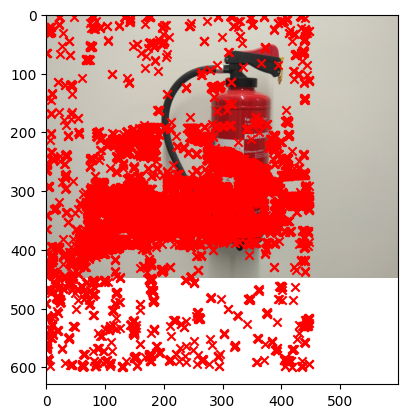

Image shape: (449, 600, 3), type: float64
Grayscale stats - min: 0.043137254901960784, max: 0.9999999999999999
Harris score - min: -0.2523691352002302, max: 0.18049881502285348
Keypoints found: 0
Percentile-based keypoints: 13470


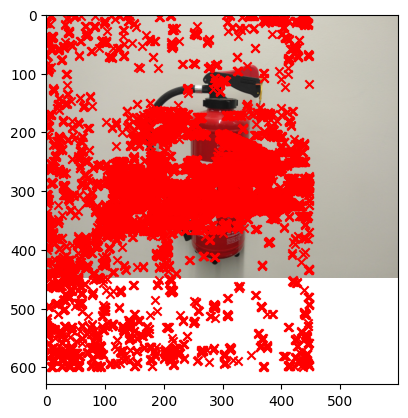

In [101]:
def plot_keypoints(img, points):
    plt.imshow(img)
    plt.scatter(points[:,0], points[:,1], marker='x', color='r')
    plt.show()


keypoints = {}
for i, target_image in  enumerate([view1, view2]):
    points, angles = detect_corner_keypoints(target_image, window_size=5, threshold=10)
    keypoints[f"view{i+1}"] = (points, angles)
    plot_keypoints(target_image, points)

If you did everything correctly you should already be able to spot some key points that correspond to the same real point in both views. Sofar the key points are robust in terms of rotation and translation. To become more robust against changes in scale, we would need to further extend our implementation. However this not in the scope of the exercise. But here is a sketch of the idea:

To achieve scale invariance we will detect corner key points at multiple scales of the input image. First, we will create a Gaussian pyramid of the image, i.e, we will blur the image and subsample by a factor of 2. We continue doing so until the image reaches a limit, say 32x32 pixels... Then, we will compute key points for each scale image and determine their location with respect to the original resolution. Afterwards, we supress duplicates.

### 1.2 Select patches around key points
 
Right now, we are aware of the keypoints in the image. However, we would like to have a unique description of every keypoint to rediscover it also in other views of the same scene. Therefore, we need to take a look at the proximity of the key point and encode the information we find there. We choose a patch of size 16x16 around each key point to extract information and transform them into a descriptor. The patches are rotated according to the key point orientation.

First, use the following plotting function to visulize the patches.

In [102]:
import matplotlib.patches as patches
from matplotlib.transforms import Affine2D

def plot_patches(img, keypoints, angles):
    """
    :param img: image
    :param keypoints: Numpy array containig the keypoints
    :param rotations: Numpy array of length=len(keypoints) containing
                      the patch rotation
    """
    scales = np.ones(len(keypoints))*16    
    ax = plt.gca()
    ax.imshow(img)
    ax.scatter(points[:,0], points[:,1], marker='.', alpha=0.7, color='r')
    for kp, angle, length in zip(keypoints, angles, scales):
        rect = patches.Rectangle(kp - length / 2, length, length, linewidth=1,
                                 edgecolor='r', facecolor='none')
        transform = Affine2D().rotate_deg_around(*kp, angle) + ax.transData
        rect.set_transform(transform)
        ax.add_patch(rect)
        
    plt.show()

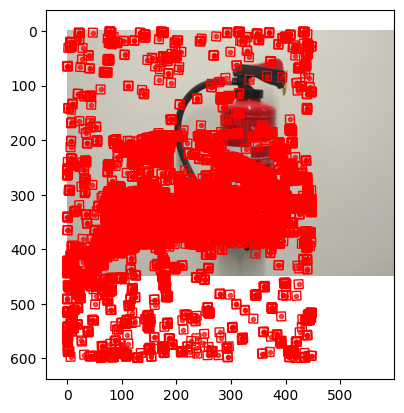

KeyboardInterrupt: 

In [103]:
for i, target_image in  enumerate([view1, view2]):
    points, angles = keypoints[f"view{i+1}"]
    plot_patches(target_image, points, angles)

Now, complete the function that extracts the patches from a given view and returns them as 16x16 grayscale numpy arrays. Obviously, the array of patches shall have the same ordering as the key points. You may use `skimage.transform.rotate` to rotate the image before extracting the patches. Also, cropping the image before rotating will speed up your runtime.

Hint: You can pad the image using `np.pad` if the patches are extracted add the borders

In [ ]:
from skimage.transform import rotate

def extract_patches(img, keypoints, angles, patch_size=16):
    """
    Extract oriented patches around the detected key points.
    """
    # Convert to grayscale
    if len(img.shape) == 3:
        monochrome_img = to_grayscale(img)
    else:
        monochrome_img = img
    
    # Add padding to the image
    pad_size = patch_size // 2
    padded_img = np.pad(monochrome_img, pad_size, mode='constant', constant_values=0)
    
    # Extract patches
    patches = []
    for (y, x), angle in zip(keypoints, angles):  # Note: (y, x) for indexing
        # Adjust keypoint coordinates for padding
        y_padded, x_padded = y + pad_size, x + pad_size
        
        # Extract patch
        patch = padded_img[y_padded - pad_size:y_padded + pad_size, 
                           x_padded - pad_size:x_padded + pad_size]
        
        # Rotate the patch by the angle
        rotated_patch = rotate(patch, angle=np.degrees(angle), resize=False, mode='constant', cval=0)
        
        # Append the patch
        patches.append(rotated_patch)
    
    # Return patches as a 3D array
    return np.array(patches)


In [ ]:
patches_view1 = extract_patches(view1, *keypoints["view1"])
patches_view2 = extract_patches(view2, *keypoints["view2"])

In [ ]:
def plot_patch_crops(patches):
    # define image grind
    cols = 10
    rows = int(np.ceil(len(patches) / cols))
    
    # create subplots
    _, axes = plt.subplots(rows, cols, figsize=(16, rows * 3 ))
    axes = axes.flatten()
    for patch, ax in zip(patches,axes):
        ax.imshow(patch)
    plt.show()

In [ ]:
print(f"Keypoints for view1: {keypoints['view1']}")
print(f"Number of keypoints: {len(keypoints['view1'][0])}")
plot_patch_crops(patches_view1)

Keypoints for view1: (array([], shape=(0, 2), dtype=int64), array([], dtype=float64))
Number of keypoints: 0


ValueError: Number of rows must be a positive integer, not 0

<Figure size 1600x0 with 0 Axes>

In [ ]:
plot_patch_crops(patches_view2)

ValueError: Image size of 1600x404100 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1600x404100 with 13470 Axes>

If you analyze the extracted patches from both views you should notice that some of them already look quite similar to patches from the other view. Now, we will construct a feature descriptor from them.

### 1.3. Computing the Feature Descriptor

There are different options to utilize the patch information and transform them into a feature representation. An intuitive approach is to compare the images by their color or color histograms. Yet, this reduces the robustness of our method to changes in lighting. Instead, we use image gradients as motivated in the [SIFT](https://link.springer.com/article/10.1023/B:VISI.0000029664.99615.94) paper and in the lecture.

To implement this descriptor you may reuse most of your code from the `extract_patches` method in the previous section. You again extract patches but this time not from the grayscale image but from the gradient images, i. e., the gradient image in $x$ and $y$ direction. Afterwards, you compute the gradient length and orientation for every pixel in the patch. The gradient magnitudes are weighted by a gaussian kernel of the same size as the patch and $\sigma=0.5 \cdot patch size$. Finally, the patch is separated into a 4x4 grid where each cell consists of an 4x4 pixels subpatch. For each of these subpatches an 8-bin histogram is computed over the orientations of the gradients in that cell. For example, all gradients with orientation between 0 - 45 degrees are counted in the first histogram bin. All gradients with orientation between 45-90 in the second and so on. Instead of increasing the counter by one for each gradient, we increase it by the weighted magnitude. In total, we have eight counts per cell and 16 cells in total which results in a 128-dimenstional feature vector which we will use to describe the keypoint. In the end, this feature vector shall be nomalized to unit length.

Hint: For histogram binning you can use `np.histogram` which already provides you with weighted bin counting.

In [ ]:
from scipy.stats import multivariate_normal


# you may use this function to get the gaussian weights to weight the gradient magnitudes
def get_gaussian_weights(std, size):
    mvn = multivariate_normal(mean=[0,0], cov=[[std,0.],[0., std]])
    xs = np.arange((1 - size) / 2, (size + 1) / 2)
    xs, ys = np.meshgrid(xs,xs)
    pos = np.dstack((xs, ys))
    return mvn.pdf(pos)

def get_gradient_orientations(grad_patches_x: npt.ArrayLike, grad_patches_y: npt.ArrayLike) -> np.ndarray:
    """Compute the gradient orientation."""
    return np.arctan2(grad_patches_y, grad_patches_x)


def get_gradient_magnitudes(grad_patches_x: npt.ArrayLike, grad_patches_y: npt.ArrayLike) -> np.ndarray:
    """Compute the gradient magnitudes."""
    return np.sqrt(grad_patches_x**2 + grad_patches_y**2)


def add_magnitude_weighting(magnitudes: npt.ArrayLike, patch_size: int) -> np.ndarray:
    """Add weighting for the magnitudes."""
    std = patch_size / 6  # Standard deviation as a fraction of patch size
    gaussian_weights = get_gaussian_weights(std, patch_size)
    return magnitudes * gaussian_weights


def create_features(keypoints: npt.ArrayLike, magnitudes: npt.ArrayLike, orientations: npt.ArrayLike, patch_size: int, cell_size: int, histogram_bins: int) -> np.ndarray:
    """Create feature vectors."""
    num_cells = patch_size // cell_size
    bin_width = 2 * np.pi / histogram_bins
    
    features = []
    for idx in range(len(keypoints)):
        patch_magnitudes = magnitudes[idx]
        patch_orientations = orientations[idx]
        feature_vector = []

        for i in range(num_cells):
            for j in range(num_cells):
                # Extract cell
                cell_magnitudes = patch_magnitudes[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
                cell_orientations = patch_orientations[i * cell_size:(i + 1) * cell_size, j * cell_size:(j + 1) * cell_size]
                
                # Compute histogram for the cell
                cell_histogram = np.zeros(histogram_bins)
                for bin_idx in range(histogram_bins):
                    lower_bound = bin_idx * bin_width
                    upper_bound = (bin_idx + 1) * bin_width
                    mask = (cell_orientations >= lower_bound) & (cell_orientations < upper_bound)
                    cell_histogram[bin_idx] += np.sum(cell_magnitudes[mask])
                
                feature_vector.extend(cell_histogram)
        
        features.append(feature_vector)
    
    return np.array(features)


def create_descriptors(img, keypoints, angles, patch_size=16, cell_size=4, histogram_bins=8):
    """
    Creates descriptors from oriented patches around each key point.
    """
    assert patch_size % cell_size == 0, "patch_size must be evenly divisible by cell_size"

    # 1. Convert to grayscale
    monochrome_img = to_grayscale(img)

    # 2. Compute image gradients
    smoothed_img = gaussian_filter(monochrome_img, sigma=1)
    Ix, Iy = sobel(smoothed_img, axis=1), sobel(smoothed_img, axis=0)

    # 3. Compute gradient patches
    grad_patches_x = extract_patches(Ix, keypoints, angles, patch_size)
    grad_patches_y = extract_patches(Iy, keypoints, angles, patch_size)

    # 4. Compute gradient orientations and magnitudes
    orientations = get_gradient_orientations(grad_patches_x, grad_patches_y)
    magnitudes = get_gradient_magnitudes(grad_patches_x, grad_patches_y)

    # 5. Apply magnitude weighting
    weighted_magnitudes = add_magnitude_weighting(magnitudes, patch_size)

    # 6. Create feature vectors
    features = create_features(keypoints, weighted_magnitudes, orientations, patch_size, cell_size, histogram_bins)

    # 7. Return feature vectors
    return features


In [ ]:
features = {}
features["view1"] = create_descriptors(view1, *keypoints['view1'], patch_size=16, cell_size=4)
features["view2"] = create_descriptors(view2, *keypoints['view2'], patch_size=16, cell_size=4)

## 2. Feature Matching

Now that we have found image key points and assigned them a (hopefully) unique descriptor, it is time to find corresponding points in both images. There are sophisticated matching algorithms which avoid checking every key point from one view with the one from another view. However, for the sake of this exercise comparing all key points is our way to go. As we encoded the appearance of each key point by a feature vector, we can easily compute its sum of squared differences to all other feature vectors.

Hence, your first task is to compute the sum of squared differences between all key points in both views.
The result should be a matrix $D$ where $d_{ij} = \| f_i-f_j\|_2^2$ and $f_i, f_j$ are the feature vectors from key points i and j. Note that key points i come from view 1 and key points j from view 2.

$D$ can be displayed by matplotlib which shows you how close the points are to others.

In [ ]:
features_view1 = features["view1"]
features_view2 = features["view2"]

def get_distances(features_view1: npt.ArrayLike, features_view2: npt.ArrayLike) -> np.ndarray:
    """
    Compute the distance matrix between the feature vectors.
    """
    # Use broadcasting for efficient distance computation
    distances = np.sqrt(np.sum((features_view1[:, np.newaxis, :] - features_view2[np.newaxis, :, :])**2, axis=2))
    return distances

D = get_distances(features_view1, features_view2)

plt.imshow(D)
plt.show()

MemoryError: Unable to allocate 173. GiB for an array with shape (13470, 13470, 128) and data type float64

We see that there is a lot of ambiguity for some points. Hence, it may not be enough to choose the best pair of points but only pairs where the second best match is significantly worse. A simple method to do so is a ratio test. We check if the ratio between the shortest distance $d_1$ of the best match and the distance $d_2$ of the second best match is smaller than some threshold $T$. If so, we return the matched pair otherwise no match is returned.

Using this as a check, you can implement a simple matching function. You can verify the outputs by using the visualization function provided below. The function you are about to implement should also return the distance of the points in each match. You may sort the list of matches to see the best ones on top.

Hint: Only because key point P1 from view1 matches best with P2 from view2 doesn't mean P2 matches best with P1. The matching relation is not symmetric. So, key points might be used in different matches.

In [ ]:
from matplotlib.patches import ConnectionPatch

# use this function to visualize the matches
def plot_matches(img1, img2, keypoints1, keypoints2, matches):
    fig, axes = plt.subplots(1,2,figsize=(16,7))
    
    # draw images
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    
    # draw matches
    for index_1, index_2 in matches:
        kp1, kp2 = keypoints1[index_1], keypoints2[index_2]
        con = ConnectionPatch(xyA=kp1, coordsA=axes[0].transData,
                              xyB=kp2, coordsB=axes[1].transData, color='r')
        fig.add_artist(con)
        axes[0].plot(*kp1, color='r', marker='x')
        axes[1].plot(*kp2, color='r', marker='x')
    
    plt.show()
    

In [ ]:
def get_matches(distances: npt.ArrayLike, threshold: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Get matching keypoints.
    """
    matches = []
    match_distances = []

    for i in range(distances.shape[0]):
        # Find the two smallest distances for the current keypoint
        sorted_indices = np.argsort(distances[i])
        best_match_idx = sorted_indices[0]
        second_best_match_idx = sorted_indices[1]
        best_distance = distances[i, best_match_idx]
        second_best_distance = distances[i, second_best_match_idx]

        # Ratio test
        if best_distance < threshold * second_best_distance:
            matches.append((i, best_match_idx))
            match_distances.append(best_distance)

    return np.array(matches), np.array(match_distances)


def remove_duplicate_matches(matches: npt.ArrayLike, match_distances: npt.ArrayLike) -> tuple[np.ndarray, np.ndarray]:
    """
    Remove duplicate matches by keeping the match with the smallest distance.
    """
    unique_matches = {}
    for idx, (view1_idx, view2_idx) in enumerate(matches):
        distance = match_distances[idx]
        if view2_idx not in unique_matches or distance < unique_matches[view2_idx][1]:
            unique_matches[view2_idx] = (view1_idx, distance)

    filtered_matches = []
    filtered_distances = []
    for view2_idx, (view1_idx, distance) in unique_matches.items():
        filtered_matches.append((view1_idx, view2_idx))
        filtered_distances.append(distance)

    return np.array(filtered_matches), np.array(filtered_distances)


def match_keypoints(features_view1, features_view2, threshold=0.7):
    """
    Match keypoints between two feature sets with a ratio threshold.
    """
    # 1. Compute the distance matrix
    distances = get_distances(features_view1, features_view2)

    # 2. Retrieve best matches with the ratio test
    matches, match_distances = get_matches(distances, threshold)

    # 3. Remove duplicate matches
    unique_matches, unique_distances = remove_duplicate_matches(matches, match_distances)

    # 4. Return matches and distances
    return unique_matches, unique_distances


In [ ]:
matches, match_distances = match_keypoints(features["view1"], features["view2"])

# Sort matches by their distances in ascending order
sorted_indices = np.argsort(match_distances)
sorted_matches = matches[sorted_indices]
sorted_distances = match_distances[sorted_indices]


# choose k best matches
# Define k
k = 20  # Choose the number of matches you want to visualize

# Select top-k matches
top_k_matches = sorted_matches[:k]

# visualize
plot_matches(view1, view2, keypoints["view1"][0], keypoints["view2"][0], top_k_matches)